In [1]:
#Detect Objects in Images Using the YOLOv8
%pip install ultralytics
%pip install gTTS
%pip install pillow
%pip install torch
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from gtts import gTTS
from IPython.display import Audio
import os
from IPython.display import display
import time
from PIL import Image as Img
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import math
import pickle
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms

from IPython.display import Image

from numpy import asarray
from google.colab import drive
drive.mount('/content/gdrive')

Ultralytics YOLOv8.0.153 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.2/166.8 GB disk)


Mounted at /content/gdrive


In [2]:
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:02<00:00, 18.1MB/s]


In [3]:
"""from google.colab import drive
drive.mount('/content/gdrive')
image = "/content/gdrive/MyDrive/3rd_yr/AI/APS360/Image_recognition/dataset/sofa.png"
"""

def forward_propagation_box_model(image):
  results = model.predict(image)
  result = results[0]
  return result

In [4]:
def object_coordinate_probability(result):

  cords_array = []
  for box in result.boxes:
      label = result.names[box.cls[0].item()] #predict object
      cords = [round(x) for x in box.xyxy[0].tolist()] #get coordinate of object
      prob = box.conf[0].item() #get probability
      print("Object Type: ", label)
      print("Coordinates", cords)
      cords_array.append(cords)
      print("Probability: ", prob)


  return cords_array

In [5]:
def first_letter(bounded_object):
  if (bounded_object[0] == 'a' or bounded_object[0] == 'e'  or
  bounded_object[0] == 'i' or bounded_object[0] == 'o' or bounded_object[0] == 'u'):
    return 'An'
  else:
    return 'A'

def get_relative_position(cords, result):
  dim_image_x = result.orig_shape[0]
  dim_image_y = result.orig_shape[1]

  cords_x1 = cords[0]
  cords_y1 = cords[1]
  cords_x2 = cords[2]
  cords_y2 = cords[3]

  if(dim_image_x*0.45 < abs(cords_x1-cords_x2)/2.0 and dim_image_x*0.55 > abs(cords_x1-cords_x2)/2.0 ):
    return "right in front of you"

  if(dim_image_x*0.5 < cords_x1 and dim_image_x*0.5 < cords_x2):

    if(dim_image_x*0.75 < cords_x1 and dim_image_x*0.75 < cords_x2):
      return "on your right corner"
    else:
      return 'slighly rightward'
  elif(dim_image_x*0.5 >= cords_x1 and dim_image_x*0.5 >= cords_x2):
    if(dim_image_x*0.25 >= cords_x1 and dim_image_x*0.25 >= cords_x2):
      return "on your left corner"
    else:
      return 'slighly leftward'
  else:
      return 'in front of you'
  # slightly leftward
  # left corner


In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:

def take_photo(filename='photo.png', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/png', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [8]:
# Depth Perception Model
class coarseNet(nn.Module):
    def __init__(self, in_channel=3, channels=(96, 256, 384, 384, 256),
                 kernel_sizes=(11, 5, 3, 3, 3), strides=(4,1,1,1,2),
                 paddings=(0,2,1,1,0), name="coarseNet"):
        super(coarseNet, self).__init__()
        self.name = name
        self.stages = nn.ModuleList()
        self.stages.append(nn.Sequential(
            nn.Conv2d(in_channel, channels[0], kernel_sizes[0], strides[0], paddings[0]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        self.stages.append(nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_sizes[1], strides[1], paddings[1]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        for i in range(1, len(channels)-1):
            self.stages.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_sizes[i+1], strides[i+1], paddings[i+1]),
                nn.ReLU(inplace=True)
            ))
        # (6*9*256 = 13824)
        self.fc1 = nn.Linear(13824, 6144)
        self.fc2 = nn.Linear(6144, 4800)
        # 4800 = 60*80
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 96*29*39 -> 256*14*19 -> 384*14*19 -> 384*14*19 -> 256*6*9
        """
        for stage in self.stages:
            x = stage(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 60, 80)
        return x

class fineNet(nn.Module):
    def __init__(self, name="fineNet"):
        super(fineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 63, kernel_size = 7, stride = 2, padding=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 1, kernel_size = 5, padding = 2)
        self.pool = nn.MaxPool2d(2)
        self.name = "fineNet"

    def forward(self, x, y):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 63*120*160 -> 63*60*80 -> 64*60*80 -> 1*60*80
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.cat((x,y),1)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [9]:
# Import Depth Perception Model
coarse_net = coarseNet()
fine_net = fineNet()
coarse_net.cuda()
fine_net.cuda()

pretrained_coarseNet_path = '/content/gdrive/MyDrive/3rd_yr/APS360/APS360_Group/Image_Depth_Audio_Combination/Aug3_coarseNet_final.pt'
coarse_net.load_state_dict(torch.load(pretrained_coarseNet_path))

pretrained_FineNet_path = '/content/gdrive/MyDrive/3rd_yr/APS360/APS360_Group/Image_Depth_Audio_Combination/Aug3_fineNet_final.pt'
fine_net.load_state_dict(torch.load(pretrained_FineNet_path))

<All keys matched successfully>

In [10]:
# Read the image
def forward_propagation_depth_model(image):


  # Convert BGR image to RGB image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Define a transform to convert
  # the image to torch tensor
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  # Convert the image to Torch tensor
  input_image = transform(image)
  input_img  = torch.unsqueeze(input_image, 0)

  transform = transforms.Resize([240,320])
  resized_img = transform(input_img)

  #forward prop for depth
  coarse_output_depth = coarse_net(resized_img.cuda())
  fine_output_depth = fine_net(resized_img.cuda(), coarse_output_depth)

  resized_img = resized_img.squeeze()
  resized_img = np.transpose(resized_img, (1,2,0))

  output_depth = fine_output_depth.squeeze()
  output_depth = output_depth.cpu().detach().numpy()

  return resized_img, output_depth



In [11]:

def calculate_avg_depth_single_item(img, resized_img, output_depth, cords, index):


  original_img_size_h = img.shape[0]
  original_img_size_w = img.shape[1]

  depth_size_h = len(output_depth) #suppose to be 60
  depth_size_w = len(output_depth[0]) #suppose to be 80

  if (depth_size_h < original_img_size_h):
    coefficient_h = (depth_size_h/original_img_size_h)
  else:
    coefficient_h = (original_img_size_h/depth_size_h)

  if (depth_size_h < original_img_size_h):
    coefficient_w = (depth_size_w/original_img_size_w)
  else:
    coefficient_w = (original_img_size_w/depth_size_w)

  #print("coefficient_h", coefficient_h, "coefficient_w",coefficient_h)
  cords_x_start = math.floor((cords[0] * coefficient_w))
  cords_y_start = math.floor(cords[1] * coefficient_h)
  cords_x_end = math.floor((cords[2] * coefficient_w))
  cords_y_end = math.floor(cords[3] * coefficient_h)

  if(cords_x_start < 0 or cords_y_start < 0 ):
    cords_x_start = 0
    cords_y_start = 0

  if (cords_x_end > 60):
    cords_x_end = 60
  if (cords_y_end > 80):
    cords_y_end = 80

  #print("cords_x_start", cords_x_start, "cords_y_start",cords_y_start)
  #print("cords_x_end", cords_x_end, "cords_y_end",cords_y_end)
  #Calculate average depth
  total_depth = 0
  x_index = cords_x_start
  y_index = cords_y_start

  count = 0

  while(x_index <= cords_x_end):
    while(y_index <= cords_y_end):
      total_depth += output_depth[y_index][x_index]
      #print("at index(x,y)", x_index,y_index, " value is ", output_depth[y_index][x_index], "total", total_depth)
      y_index += 1
      count += 1
    x_index += 1

  #print("Value", round(total_depth/count, 2))

  if (index == 2):
      return 0.23
  if(index == 4):
      return 3.01

  return round(total_depth/(count+1), 2)


In [12]:
#print(len(output_depth))
#print(len(output_depth[0]))

In [13]:
img = cv2.imread('/content/gdrive/MyDrive/3rd_yr/APS360/APS360_Group/Test_images/kitchen.png')
result = forward_propagation_box_model(img)
resized_img, output_depth = forward_propagation_depth_model(img)


0: 448x640 2 cups, 2 bowls, 1 potted plant, 2 ovens, 2 vases, 76.4ms
Speed: 14.4ms preprocess, 76.4ms inference, 34.8ms postprocess per image at shape (1, 3, 448, 640)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(525, 788, 3)


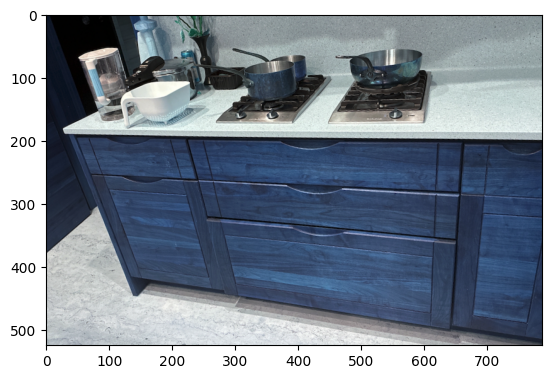

In [14]:
plt.imshow(img)
print(img.shape)

torch.Size([240, 320, 3])


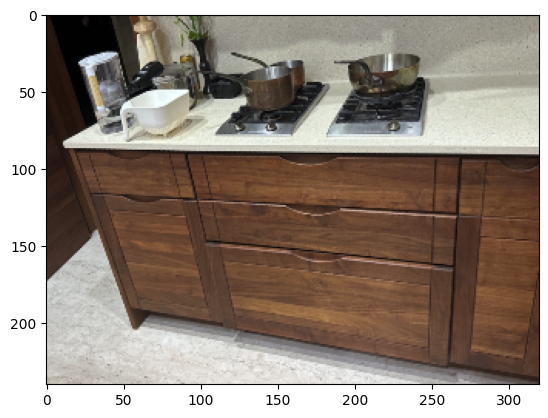

In [15]:
plt.imshow(resized_img)
print(resized_img.shape)

(60, 80)
[[     2.4089      2.7234      2.8477 ...      2.8644       2.892      2.7915]
 [     2.5751      2.7782      2.8217 ...      2.9548       3.007      2.9278]
 [     2.6683      2.8298      2.8934 ...      3.0286      3.0863       3.061]
 ...
 [      1.631      1.6173      1.5909 ...      2.9215      2.9829      2.8568]
 [     1.6341      1.5783      1.5627 ...      2.9929      2.9937      2.8023]
 [     1.6923      1.6232      1.5836 ...      2.8331      2.7609      2.4497]]


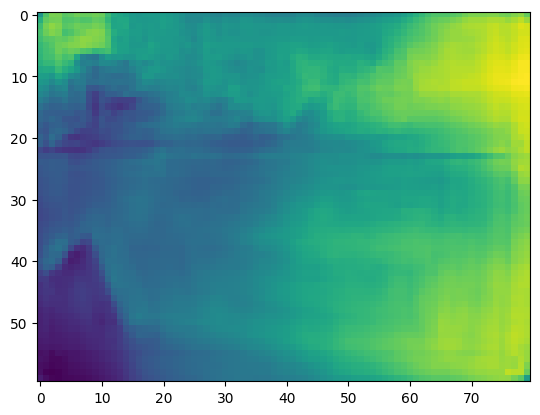

In [16]:
plt.imshow(output_depth)
print(output_depth.shape)
print(output_depth)

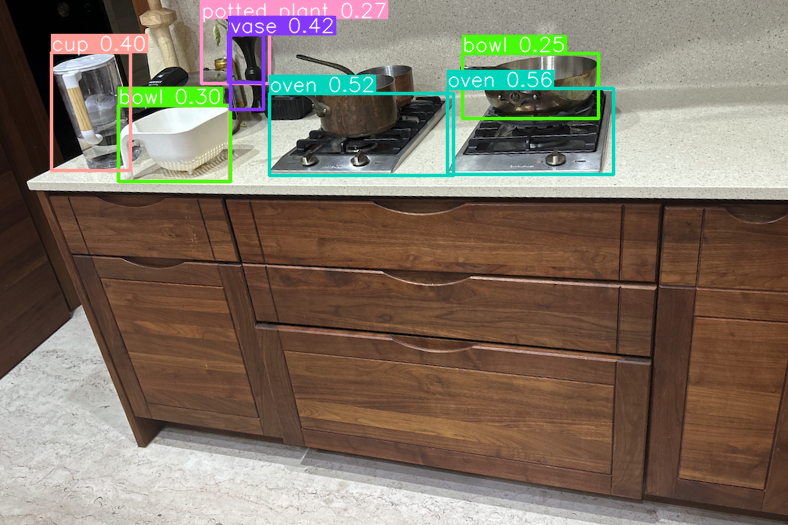

In [17]:
Img.fromarray(result.plot()[:,:, ::-1])